In [ ]:
#various necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the Wine dataset
from sklearn.datasets import load_wine
wine = load_wine()
X = wine.data
y = wine.target

In [ ]:
# Convert dataset to pandas [it will help us with visualizations]
# Combine features (X) and labels (y) into a single DataFrame
wine_df = pd.DataFrame(data=np.hstack((X, y.reshape(-1, 1))), columns=wine.feature_names + ['target'])

# Display the DataFrame
# print(wine_df)

#save some space
del X, y

In [ ]:
#now create input and output data
inputData = wine_df.iloc[:, 0:12].values
outputData = wine_df.iloc[:, 13].values

In [ ]:
#let's discuss about value range
np.set_printoptions(precision=4, suppress=True)  # Set precision and disable scientific notation
print("maximum values, per feature are: ", np.max(inputData, axis=0))
print("minimum values, per feature are: ", np.min(inputData, axis=0))

maximum values, per feature are:  [ 14.83   5.8    3.23  30.   162.     3.88   5.08   0.66   3.58  13.
   1.71   4.  ]
minimum values, per feature are:  [11.03  0.74  1.36 10.6  70.    0.98  0.34  0.13  0.41  1.28  0.48  1.27]


In [ ]:
#remember to run a normalization process (i.e. mapminmax)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
inputData = scaler.fit_transform(inputData)

In [ ]:
#let's discuss about value range
print("maximum values, per feature are: ", np.max(inputData, axis=0))
print("minimum values, per feature are: ", np.min(inputData, axis=0))

maximum values, per feature are:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
minimum values, per feature are:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# #now create some indexes for the balanced dataset
from sklearn.model_selection import train_test_split

# Split the data into train and validation indices
train_index, val_index = train_test_split(range(inputData.shape[0]),\
                                           test_size=0.1, random_state=42)

In [ ]:
#network specific libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import GaussianNoise

from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

In [ ]:
#keep some common train parameters here
#it will help test all autoencoder setup
training_epochs = 700
batch_size_num = 32

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss',\
                               patience=5, verbose=1, restore_best_weights=True)

# Define the amount of noise to be added, for the DAE
noise_factor = 0.2  # You can adjust this value as needed

# Define sampling function, for the VAE implementation
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


#select two feature idxs to demonstrate the reconstruction capabilities
features_idx_to_demonstrate = [3,6]

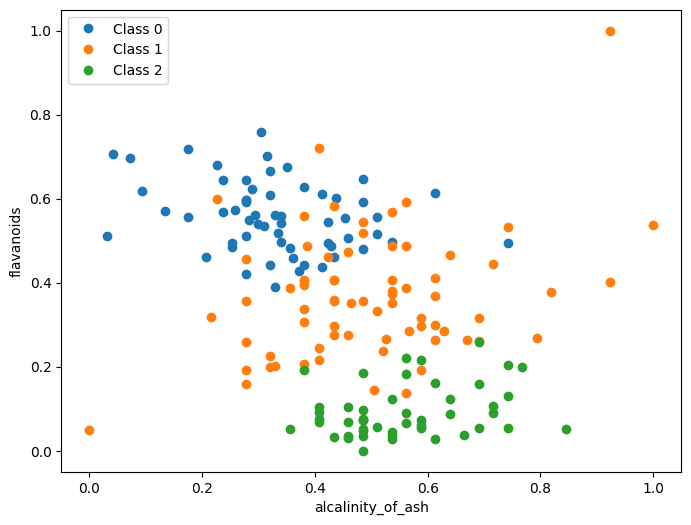

In [ ]:
original_features = inputData[:, features_idx_to_demonstrate]

# Get unique class labels
unique_labels = np.unique(outputData)

# Plot each class separately
plt.figure(figsize=(8, 6))
for label in unique_labels:
    # Filter data points belonging to the current class
    class_indices = np.where(outputData == label)[0]
    class_original_features = original_features[class_indices]
    # Plot data points with corresponding class label
    plt.plot(class_original_features[:, 0], class_original_features[:, 1], 'o', label=f'Class {int(label)}')

plt.xlabel(wine.feature_names[features_idx_to_demonstrate[0]])
plt.ylabel(wine.feature_names[features_idx_to_demonstrate[1]])
plt.legend()
plt.show()


Restoring model weights from the end of the best epoch: 357.
Epoch 362: early stopping


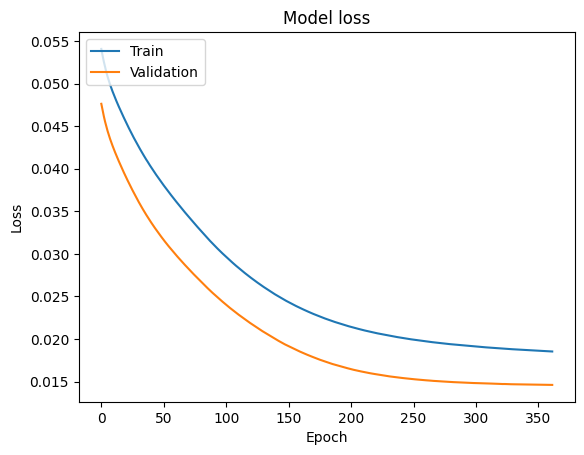

In [ ]:
# a simple autoencoder

# Input layer
input_layer = Input(shape=(12,))
# Encoder
encoded = Dense(2, activation='relu')(input_layer)
# Decoder
decoded = Dense(12, activation='sigmoid')(encoded)

# Autoencoder model
AE = Model(input_layer, decoded)

#Compile the autoencoder
AE.compile(optimizer='adam', loss='mse')

# Train the model
history = AE.fit(inputData[train_index,:],
                    inputData[train_index,:],\
                    epochs=training_epochs, batch_size=batch_size_num,\
                    validation_data=(inputData[val_index,:],\
                                     inputData[val_index,:]),\
                    callbacks=[early_stopping],\
                    verbose=0)  # Set verbose=2 for one line per epoch)

#plot the history curves
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 66ms/step


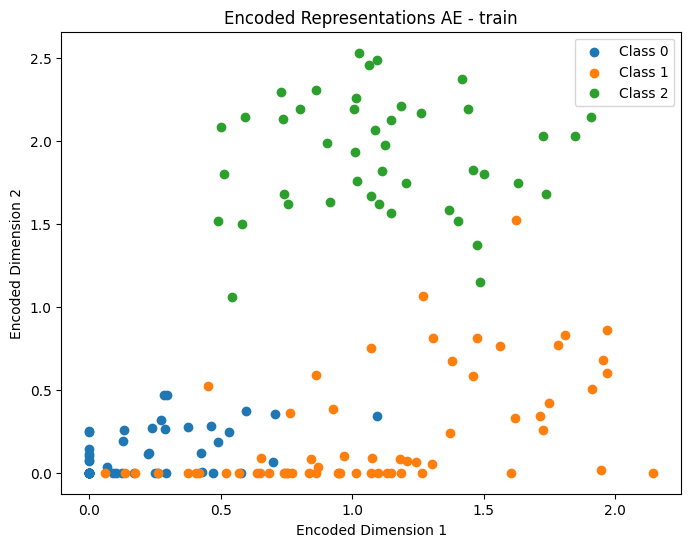

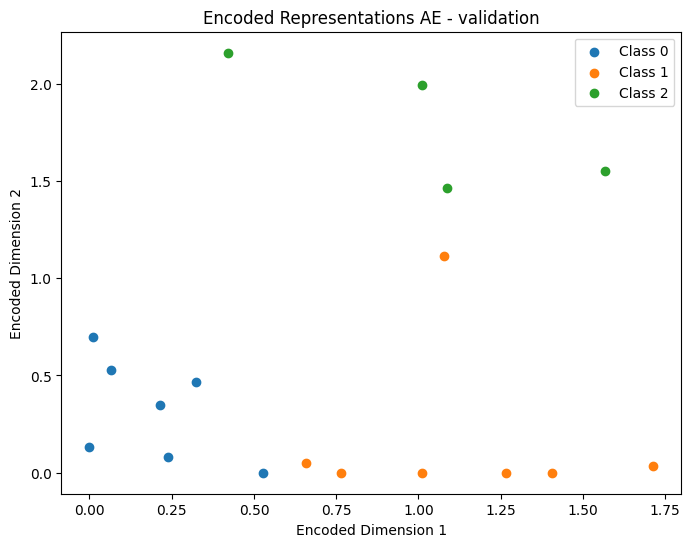

In [ ]:
#use the encoder to get the representations
encoder = Model(input_layer, encoded)
encoded_data_train = encoder.predict(inputData[train_index,:])
encoded_data_val = encoder.predict(inputData[val_index,:])

# Plot 2D scatter plot for encoded representations
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(outputData[train_index]))):
    plt.scatter(encoded_data_train[outputData[train_index]==i, 0],
                encoded_data_train[outputData[train_index]==i, 1],
                label=f'Class {i}')
plt.title('Encoded Representations AE - train')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for i in range(len(np.unique(outputData[val_index]))):
    plt.scatter(encoded_data_val[outputData[val_index]==i, 0],
                encoded_data_val[outputData[val_index]==i, 1],
                label=f'Class {i}')
plt.title('Encoded Representations AE - validation')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.legend()
plt.show()

6/6 [==============================] - 0s 2ms/step


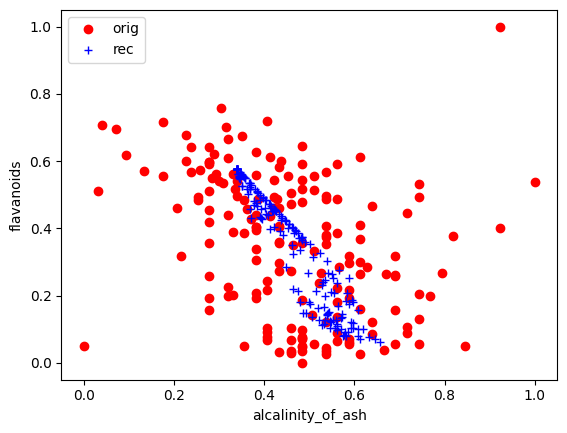

In [ ]:
original_features = inputData[:, features_idx_to_demonstrate]
reconstructed_features = AE.predict(inputData)[:, features_idx_to_demonstrate]

plt.plot(original_features[:,0], original_features[:,1], 'ro', label='orig')
plt.plot(reconstructed_features[:,0], reconstructed_features[:,1], 'b+',label='rec')
plt.xlabel(wine.feature_names[features_idx_to_demonstrate[0]])
plt.ylabel(wine.feature_names[features_idx_to_demonstrate[1]])
plt.legend()

plt.show()

In [ ]:
del encoder

Restoring model weights from the end of the best epoch: 630.
Epoch 635: early stopping


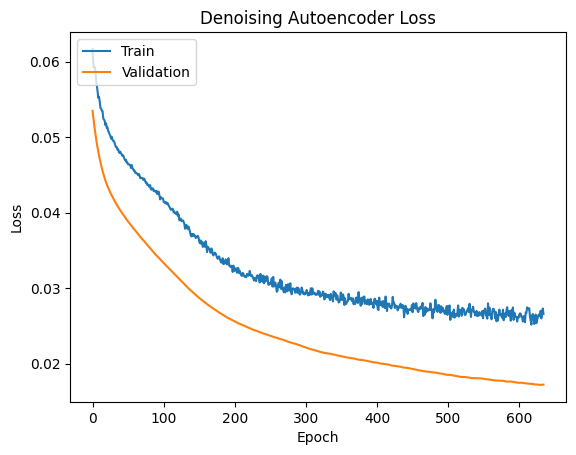

In [ ]:


# Add Gaussian noise to the input data
noisy_inputData_train = inputData[train_index,:] + noise_factor *\
 np.random.normal(loc=0.0, scale=1.0, size=inputData[train_index,:].shape)

# Input layer
input_layer = Input(shape=(12,))
# Add Gaussian noise layer
noisy_input = GaussianNoise(noise_factor)(input_layer)
# Encoder
encoded = Dense(2, activation='relu')(noisy_input)
# Decoder
decoded = Dense(12, activation='sigmoid')(encoded)

# Denoising Autoencoder model
DAE = Model(input_layer, decoded)

# Compile the denoising autoencoder
DAE.compile(optimizer='adam', loss='mse')

# Train the model
history = DAE.fit(noisy_inputData_train, inputData[train_index,:],
                  epochs=training_epochs, batch_size=batch_size_num,
                  validation_data=(inputData[val_index,:], inputData[val_index,:]),
                  callbacks=[early_stopping],
                  verbose=0)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Denoising Autoencoder Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 51ms/step


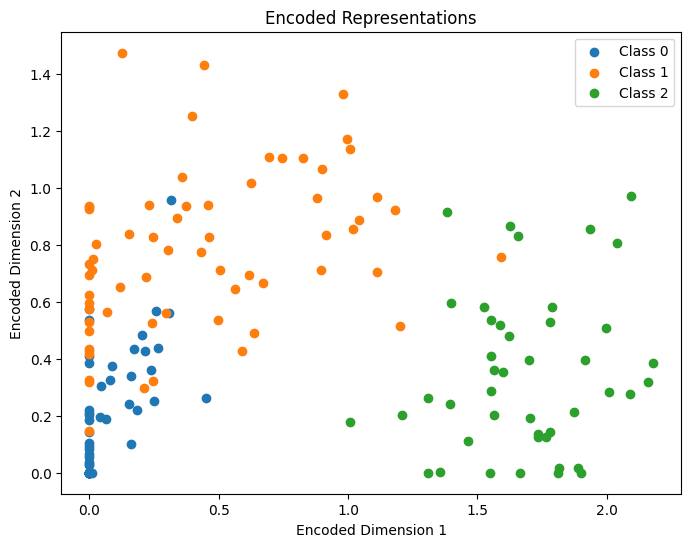

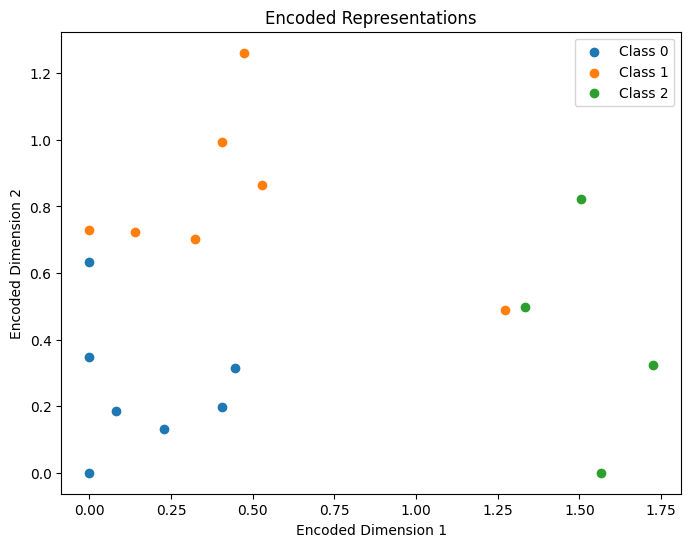

In [ ]:
#use the encoder to get the representations
encoder = Model(input_layer, encoded)
encoded_data_train = encoder.predict(inputData[train_index,:])
encoded_data_val = encoder.predict(inputData[val_index,:])

# Plot 2D scatter plot for encoded representations
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(outputData[train_index]))):
    plt.scatter(encoded_data_train[outputData[train_index]==i, 0],
                encoded_data_train[outputData[train_index]==i, 1],
                label=f'Class {i}')
plt.title('Encoded Representations')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for i in range(len(np.unique(outputData[val_index]))):
    plt.scatter(encoded_data_val[outputData[val_index]==i, 0],
                encoded_data_val[outputData[val_index]==i, 1],
                label=f'Class {i}')
plt.title('Encoded Representations')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.legend()
plt.show()

6/6 [==============================] - 0s 3ms/step


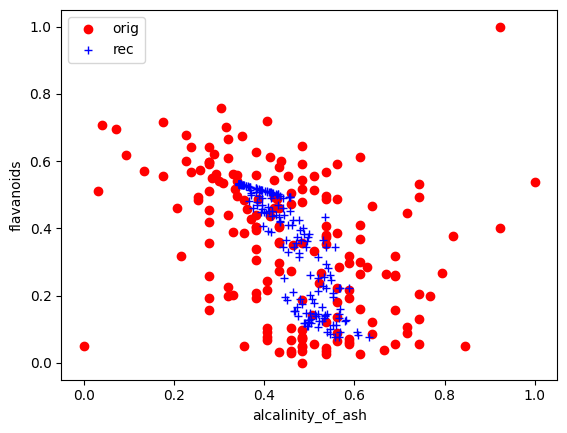

In [ ]:
original_features = inputData[:, features_idx_to_demonstrate]
reconstructed_features = DAE.predict(inputData)[:, features_idx_to_demonstrate]

plt.plot(original_features[:,0], original_features[:,1], 'ro', label='orig')
plt.plot(reconstructed_features[:,0], reconstructed_features[:,1], 'b+',label='rec')
plt.xlabel(wine.feature_names[features_idx_to_demonstrate[0]])
plt.ylabel(wine.feature_names[features_idx_to_demonstrate[1]])
plt.legend()

plt.show()

In [ ]:
del encoder

Restoring model weights from the end of the best epoch: 66.
Epoch 71: early stopping


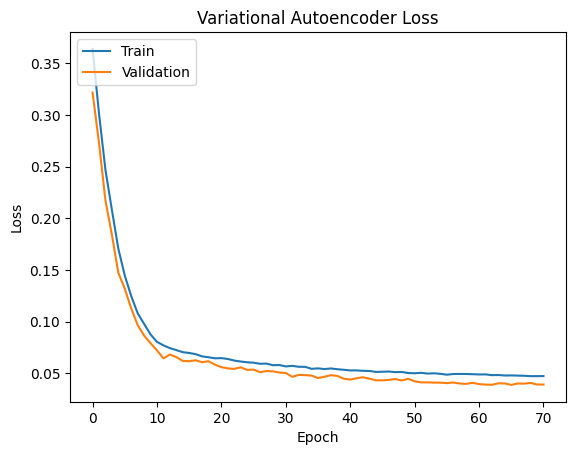

In [ ]:
#variational autoencoder

# Input layer
input_layer = Input(shape=(12,))
# Encoder
encoder_dense = Dense(16, activation='relu')(input_layer)
z_mean = Dense(2)(encoder_dense)
z_log_var = Dense(2)(encoder_dense)

# Sampling layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

# Decoder
decoder_dense = Dense(16, activation='relu')(z)
decoded = Dense(12, activation='sigmoid')(decoder_dense)

# VAE model
VAE = Model(input_layer, decoded)

# Define KL divergence loss
# kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
# vae_loss = K.mean((input_layer - decoded) ** 2 + kl_loss)
kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
reconstruction_loss = tf.reduce_mean(tf.square(input_layer - decoded), axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

# Compile the VAE
VAE.add_loss(vae_loss)
VAE.compile(optimizer='adam')

# Train the VAE
history = VAE.fit(inputData[train_index,:], inputData[train_index,:],
                  epochs=training_epochs, batch_size=batch_size_num,
                  validation_data=(inputData[val_index,:], inputData[val_index,:]),
                  callbacks=[early_stopping],
                  verbose=0)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Variational Autoencoder Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 53ms/step


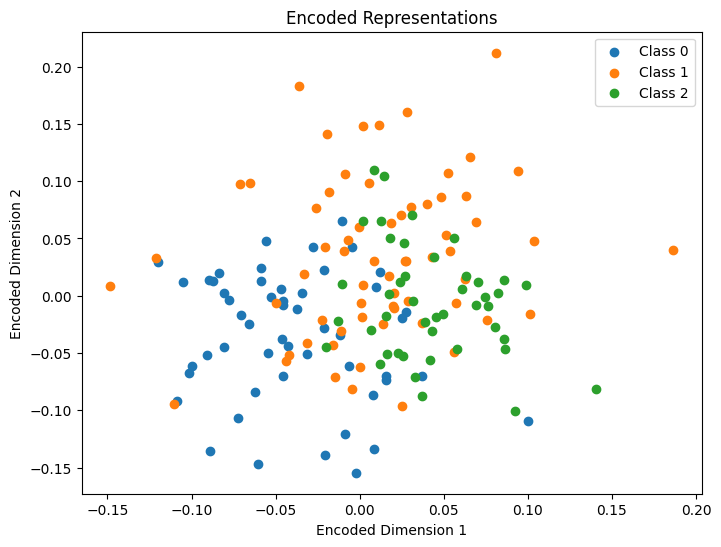

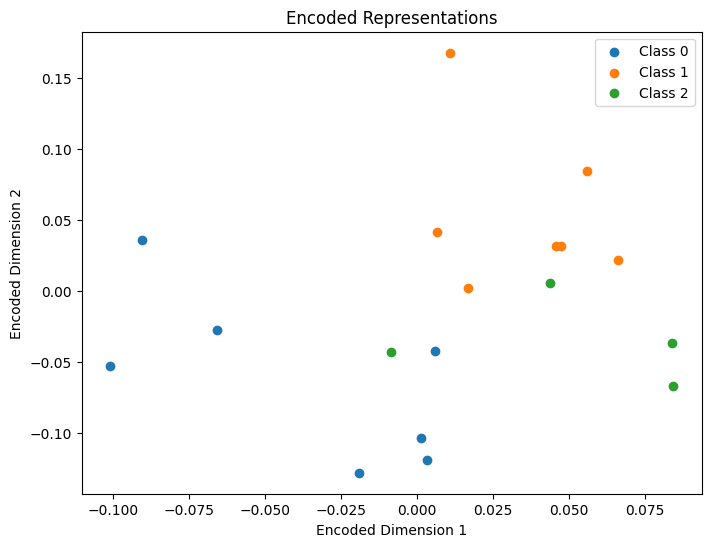

In [ ]:
# Define encoder model to get the means of the latent space distribution
encoder = Model(input_layer, z_mean)

encoded_data_train = encoder.predict(inputData[train_index,:])
encoded_data_val = encoder.predict(inputData[val_index,:])

# Plot 2D scatter plot for encoded representations
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(outputData[train_index]))):
    plt.scatter(encoded_data_train[outputData[train_index]==i, 0],
                encoded_data_train[outputData[train_index]==i, 1],
                label=f'Class {i}')
plt.title('Encoded Representations')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for i in range(len(np.unique(outputData[val_index]))):
    plt.scatter(encoded_data_val[outputData[val_index]==i, 0],
                encoded_data_val[outputData[val_index]==i, 1],
                label=f'Class {i}')
plt.title('Encoded Representations')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.legend()
plt.show()


6/6 [==============================] - 0s 3ms/step


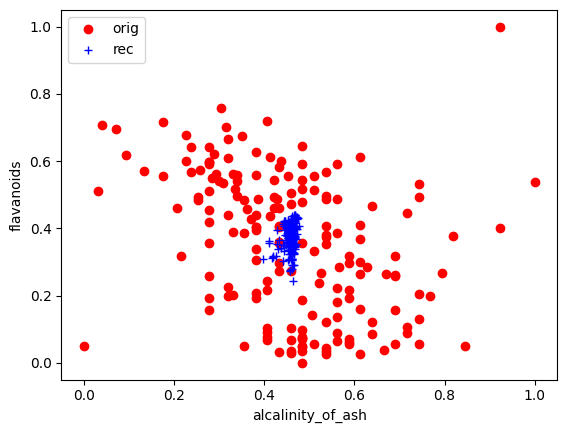

In [ ]:
original_features = inputData[:, features_idx_to_demonstrate]
reconstructed_features = VAE.predict(inputData)[:, features_idx_to_demonstrate]

plt.plot(original_features[:,0], original_features[:,1], 'ro', label='orig')
plt.plot(reconstructed_features[:,0], reconstructed_features[:,1], 'b+',label='rec')
plt.xlabel(wine.feature_names[features_idx_to_demonstrate[0]])
plt.ylabel(wine.feature_names[features_idx_to_demonstrate[1]])
plt.legend()

plt.show()

In [ ]:
del encoder

Now use the same approaches, but stacked. We have an additional layer

Restoring model weights from the end of the best epoch: 574.
Epoch 579: early stopping


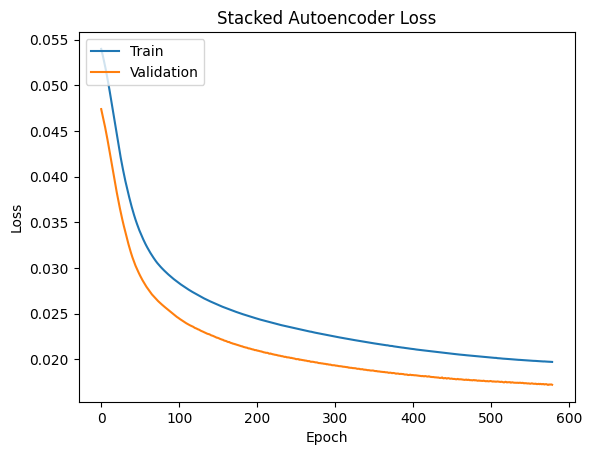

In [ ]:
#stacked autoencoder
# Input layer
input_layer = Input(shape=(12,))
# Encoder
encoded = Dense(6, activation='relu')(input_layer)  # Additional layer with 6 neurons
encoded = Dense(2, activation='relu')(encoded)
# Decoder
decoded = Dense(6, activation='relu')(encoded)  # Additional layer with 6 neurons
decoded = Dense(12, activation='sigmoid')(decoded)

# Autoencoder model
stacked_AE = Model(input_layer, decoded)

# Compile the autoencoder
stacked_AE.compile(optimizer='adam', loss='mse')

# Train the model
history = stacked_AE.fit(inputData[train_index,:],
                         inputData[train_index,:],
                         epochs=training_epochs,
                         batch_size=batch_size_num,
                         validation_data=(inputData[val_index,:], inputData[val_index,:]),
                         callbacks=[early_stopping],
                         verbose=0)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Stacked Autoencoder Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 52ms/step


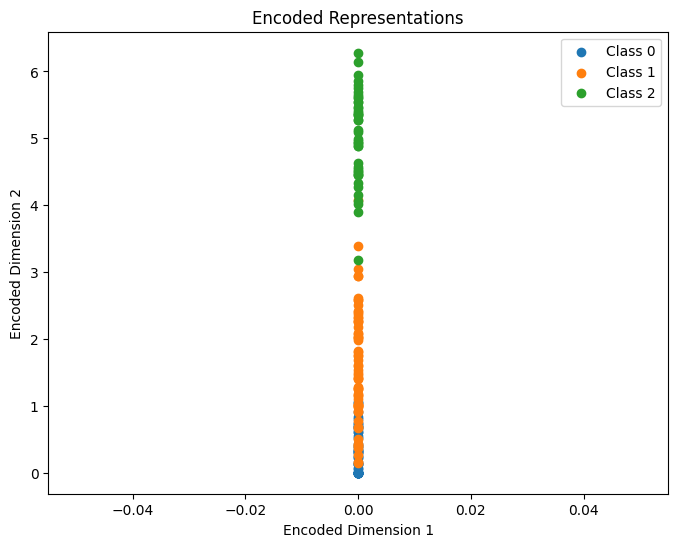

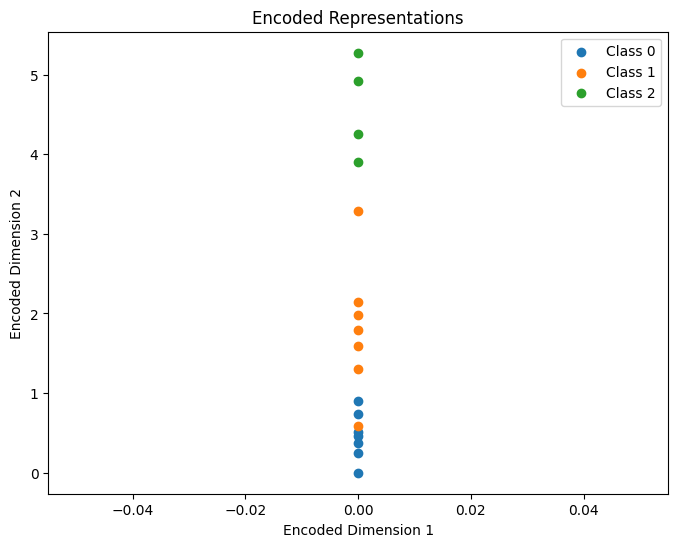

In [ ]:
#use the encoder to get the representations
encoder = Model(input_layer, encoded)
encoded_data_train = encoder.predict(inputData[train_index,:])
encoded_data_val = encoder.predict(inputData[val_index,:])

# Plot 2D scatter plot for encoded representations
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(outputData[train_index]))):
    plt.scatter(encoded_data_train[outputData[train_index]==i, 0],
                encoded_data_train[outputData[train_index]==i, 1],
                label=f'Class {i}')
plt.title('Encoded Representations')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for i in range(len(np.unique(outputData[val_index]))):
    plt.scatter(encoded_data_val[outputData[val_index]==i, 0],
                encoded_data_val[outputData[val_index]==i, 1],
                label=f'Class {i}')
plt.title('Encoded Representations')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.legend()
plt.show()

6/6 [==============================] - 0s 3ms/step


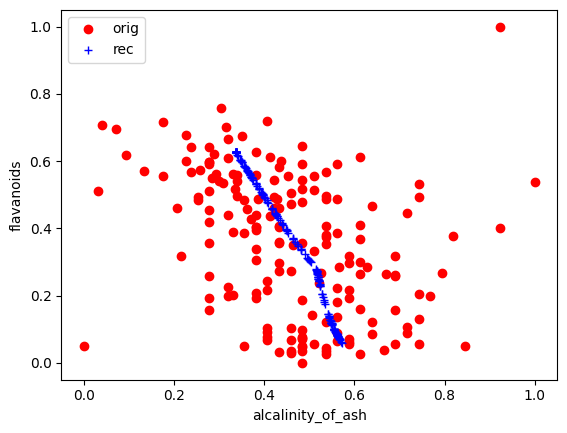

In [ ]:
original_features = inputData[:, features_idx_to_demonstrate]
reconstructed_features = stacked_AE.predict(inputData)[:, features_idx_to_demonstrate]

plt.plot(original_features[:,0], original_features[:,1], 'ro', label='orig')
plt.plot(reconstructed_features[:,0], reconstructed_features[:,1], 'b+',label='rec')
plt.xlabel(wine.feature_names[features_idx_to_demonstrate[0]])
plt.ylabel(wine.feature_names[features_idx_to_demonstrate[1]])
plt.legend()

plt.show()

In [ ]:
del encoder

Restoring model weights from the end of the best epoch: 163.
Epoch 168: early stopping


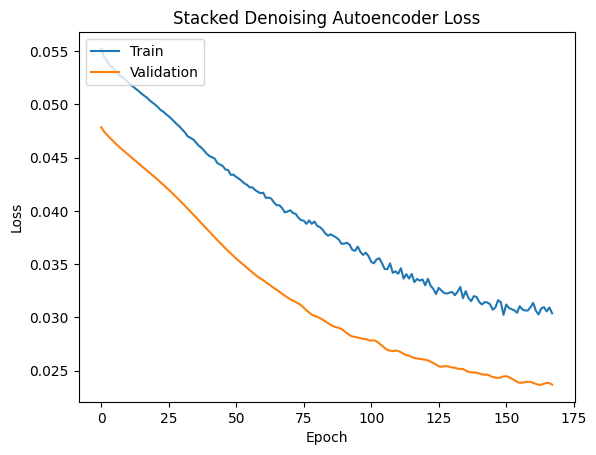

In [ ]:
#denoising SAE

# Add Gaussian noise to the input data
noisy_inputData_train = inputData[train_index,:] + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=inputData[train_index,:].shape)

# Input layer
input_layer = Input(shape=(12,))
# Add Gaussian noise layer
noisy_input = GaussianNoise(noise_factor)(input_layer)
# Encoder
encoded = Dense(6, activation='relu')(noisy_input)  # Additional layer with 6 neurons
encoded = Dense(2, activation='relu')(encoded)
# Decoder
decoded = Dense(6, activation='relu')(encoded)  # Additional layer with 6 neurons
decoded = Dense(12, activation='sigmoid')(decoded)

# Denoising Autoencoder model
stacked_DAE = Model(input_layer, decoded)

# Compile the autoencoder
stacked_DAE.compile(optimizer='adam', loss='mse')

# Train the model
history = stacked_DAE.fit(noisy_inputData_train, inputData[train_index,:],
                          epochs=training_epochs, batch_size=batch_size_num,
                          validation_data=(inputData[val_index,:], inputData[val_index,:]),
                          callbacks=[early_stopping],
                          verbose=0)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Stacked Denoising Autoencoder Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


1/1 [==============================] - 0s 63ms/step


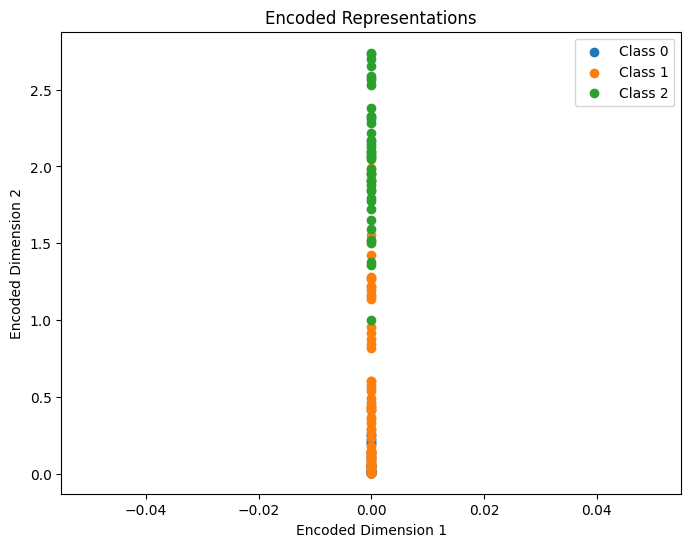

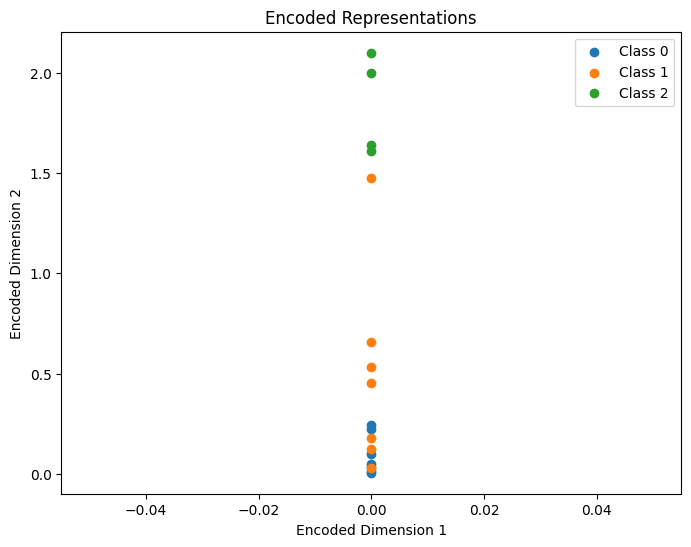

In [ ]:
#use the encoder to get the representations
encoder = Model(input_layer, encoded)
encoded_data_train = encoder.predict(inputData[train_index,:])
encoded_data_val = encoder.predict(inputData[val_index,:])

# Plot 2D scatter plot for encoded representations
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(outputData[train_index]))):
    plt.scatter(encoded_data_train[outputData[train_index]==i, 0],
                encoded_data_train[outputData[train_index]==i, 1],
                label=f'Class {i}')
plt.title('Encoded Representations')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for i in range(len(np.unique(outputData[val_index]))):
    plt.scatter(encoded_data_val[outputData[val_index]==i, 0],
                encoded_data_val[outputData[val_index]==i, 1],
                label=f'Class {i}')
plt.title('Encoded Representations')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.legend()
plt.show()

6/6 [==============================] - 0s 3ms/step


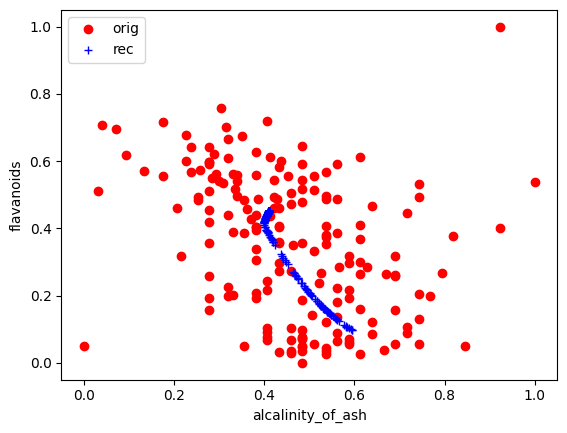

In [ ]:
original_features = inputData[:, features_idx_to_demonstrate]
reconstructed_features = stacked_DAE.predict(inputData)[:, features_idx_to_demonstrate]

plt.plot(original_features[:,0], original_features[:,1], 'ro', label='orig')
plt.plot(reconstructed_features[:,0], reconstructed_features[:,1], 'b+',label='rec')
plt.xlabel(wine.feature_names[features_idx_to_demonstrate[0]])
plt.ylabel(wine.feature_names[features_idx_to_demonstrate[1]])
plt.legend()

plt.show()

In [ ]:
del encoder

Restoring model weights from the end of the best epoch: 25.
Epoch 30: early stopping


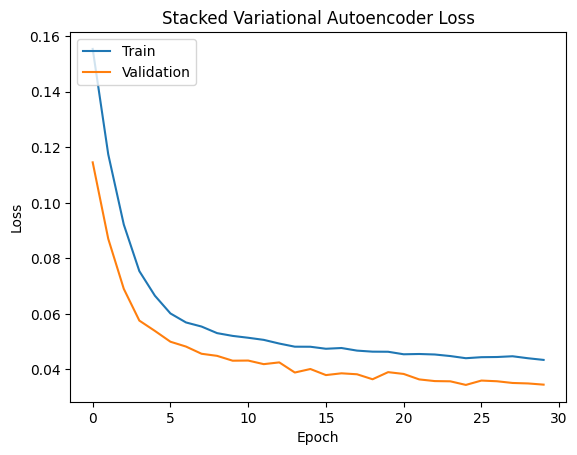

In [ ]:
#stacked VAE
# Input layer
input_layer = Input(shape=(12,))
# Encoder
encoder_dense1 = Dense(16, activation='relu')(input_layer)
encoder_dense2 = Dense(8, activation='relu')(encoder_dense1)  # Additional layer with 8 neurons
z_mean = Dense(2)(encoder_dense2)
z_log_var = Dense(2)(encoder_dense2)

# Sampling layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

# Decoder
decoder_dense1 = Dense(8, activation='relu')(z)  # Additional layer with 8 neurons
decoder_dense2 = Dense(16, activation='relu')(decoder_dense1)
decoded = Dense(12, activation='sigmoid')(decoder_dense2)

# Stacked VAE model
stacked_VAE = Model(input_layer, decoded)

# Define KL divergence loss
kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
reconstruction_loss = tf.reduce_mean(tf.square(input_layer - decoded), axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

# Compile the VAE
stacked_VAE.add_loss(vae_loss)
stacked_VAE.compile(optimizer='adam')

# Train the VAE
history = stacked_VAE.fit(inputData[train_index,:], inputData[train_index,:],
                           epochs=training_epochs, batch_size=batch_size_num,
                           validation_data=(inputData[val_index,:], inputData[val_index,:]),
                           callbacks=[early_stopping],
                           verbose=0)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Stacked Variational Autoencoder Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 74ms/step


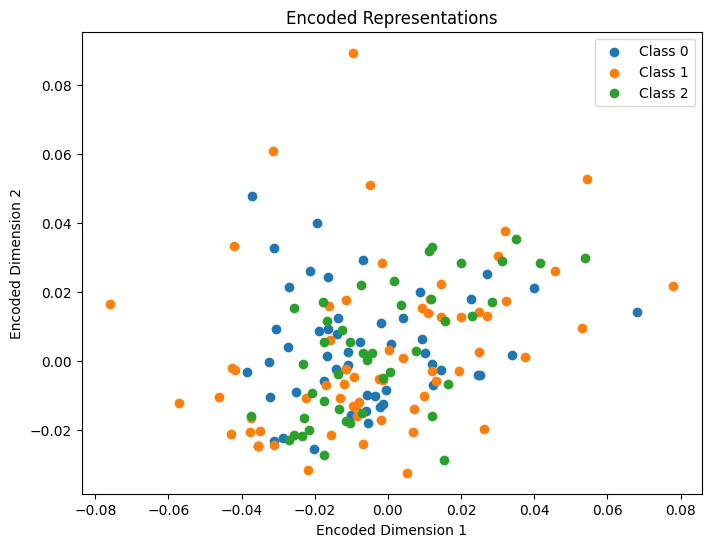

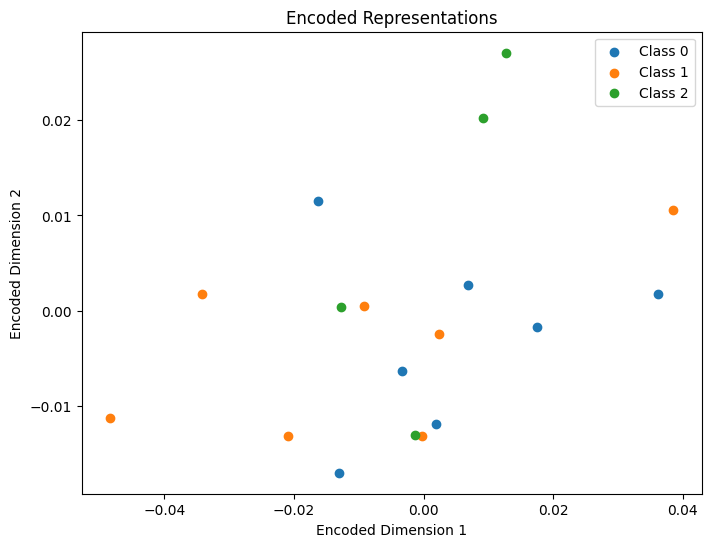

In [ ]:
# Define encoder model to get the means of the latent space distribution
encoder = Model(input_layer, z_mean)

encoded_data_train = encoder.predict(inputData[train_index,:])
encoded_data_val = encoder.predict(inputData[val_index,:])

# Plot 2D scatter plot for encoded representations
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(outputData[train_index]))):
    plt.scatter(encoded_data_train[outputData[train_index]==i, 0],
                encoded_data_train[outputData[train_index]==i, 1],
                label=f'Class {i}')
plt.title('Encoded Representations')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for i in range(len(np.unique(outputData[val_index]))):
    plt.scatter(encoded_data_val[outputData[val_index]==i, 0],
                encoded_data_val[outputData[val_index]==i, 1],
                label=f'Class {i}')
plt.title('Encoded Representations')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.legend()
plt.show()

6/6 [==============================] - 0s 3ms/step


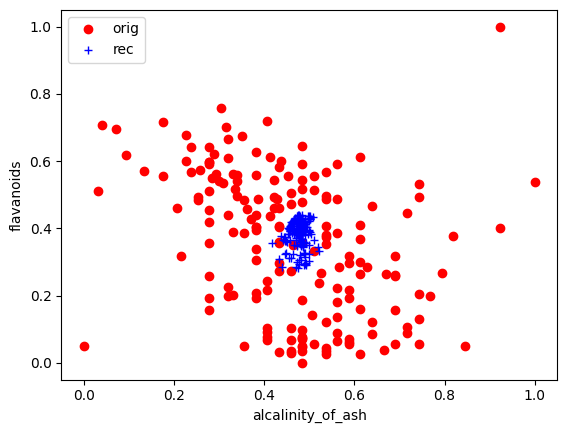

In [ ]:
original_features = inputData[:, features_idx_to_demonstrate]
reconstructed_features = stacked_VAE.predict(inputData)[:, features_idx_to_demonstrate]

plt.plot(original_features[:,0], original_features[:,1], 'ro', label='orig')
plt.plot(reconstructed_features[:,0], reconstructed_features[:,1], 'b+',label='rec')
plt.xlabel(wine.feature_names[features_idx_to_demonstrate[0]])
plt.ylabel(wine.feature_names[features_idx_to_demonstrate[1]])
plt.legend()

plt.show()

In [ ]:
del encoder